In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import torch
from torch import nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt
import time
import numpy as np

# for plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

from ph3 import *
import os
import torch.optim as optim
import torch
import pickle


In [3]:
if torch.cuda.is_available:
  print('Good to go!')
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
  print('Please set GPU via Edit -> Notebook Settings.')

# data type and device for torch.tensor
to_float = {'dtype': torch.float, 'device': 'cpu'}
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_double = {'dtype': torch.double, 'device': 'cpu'}
to_double_cuda = {'dtype': torch.double, 'device': 'cuda'}
to_long = {'dtype': torch.long, 'device': 'cpu'}
to_long_cuda = {'dtype': torch.long, 'device': 'cuda'}

Good to go!


In [4]:
# Configuration
image_size = (128, 128)
data_paht = "./dataset/archive/images"
captions_path = "./dataset/archive/captions.txt"
data_dict_path = "./dataset/image_captioning_dataset.pt"

data_dict = load_data(data_dict_path, captions_path, data_paht, image_size)

/home/mahdi/Documents/term8/CI_CNNProject_Fall2024/Phase-3/ph3.py:229: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(file_path)


Dataset loaded successfully.


In [5]:
num_train = len(data_dict['train_images'])
num_val = len(data_dict['val_images'])
print(f'num_train: {num_train}')
print(f'num_val: {num_val}')

num_train: 7281
num_val: 810


### function for data augmentation

/home/mahdi/miniconda3/envs/ml/lib/python3.8/site-packages/albumentations/augmentations/blur/transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


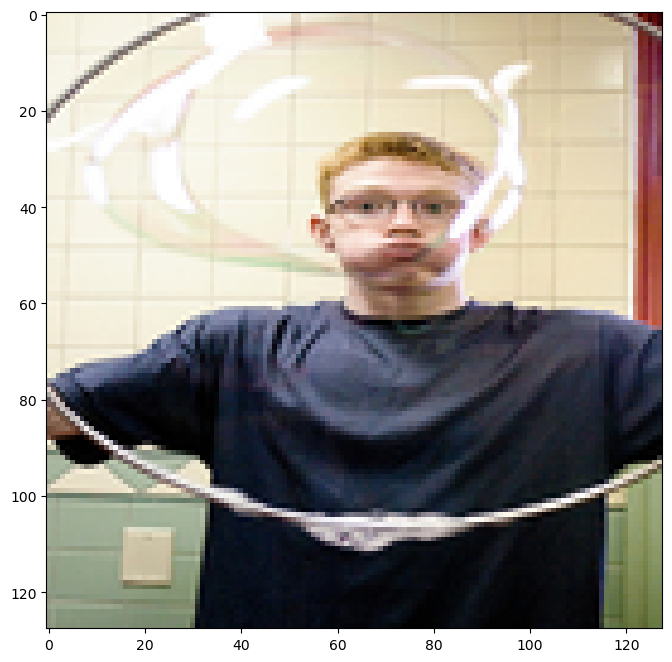

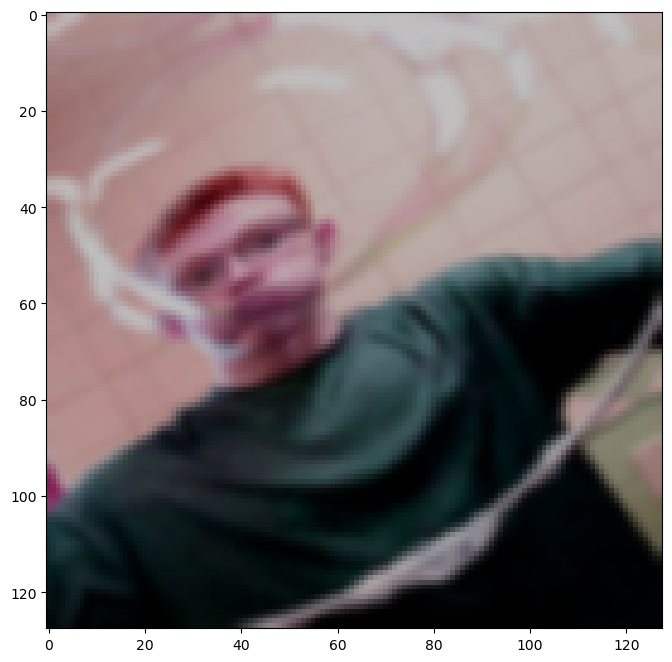

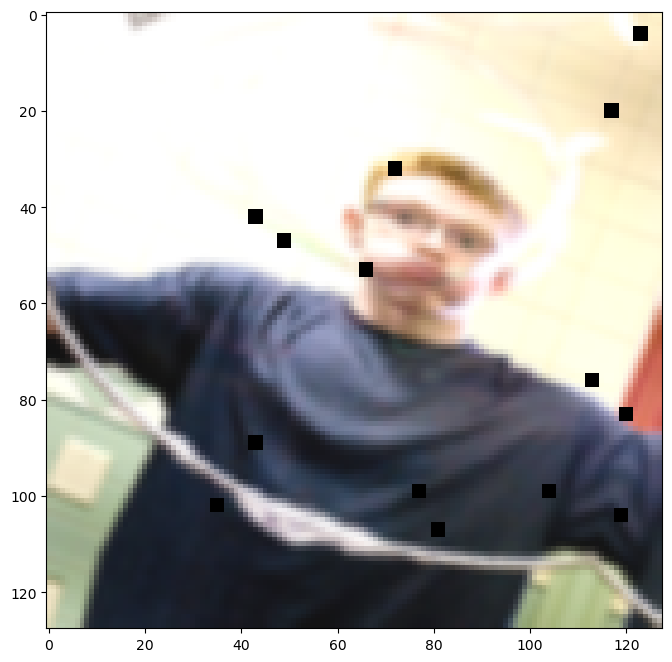

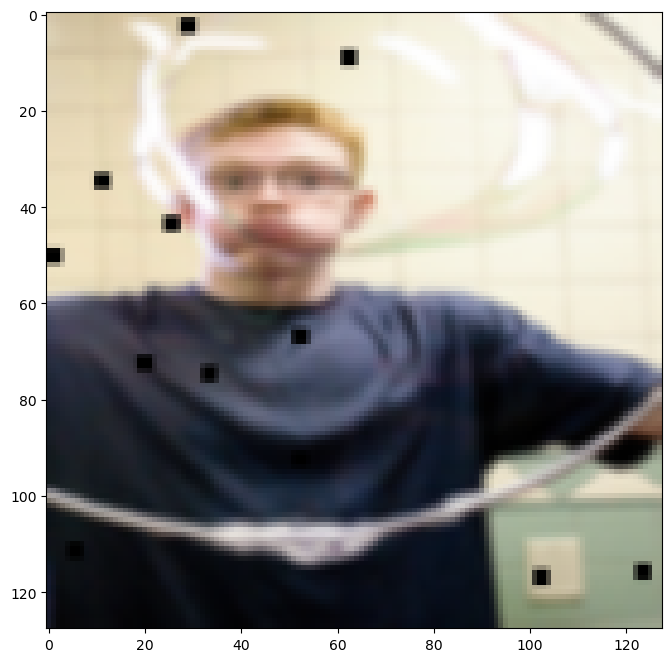

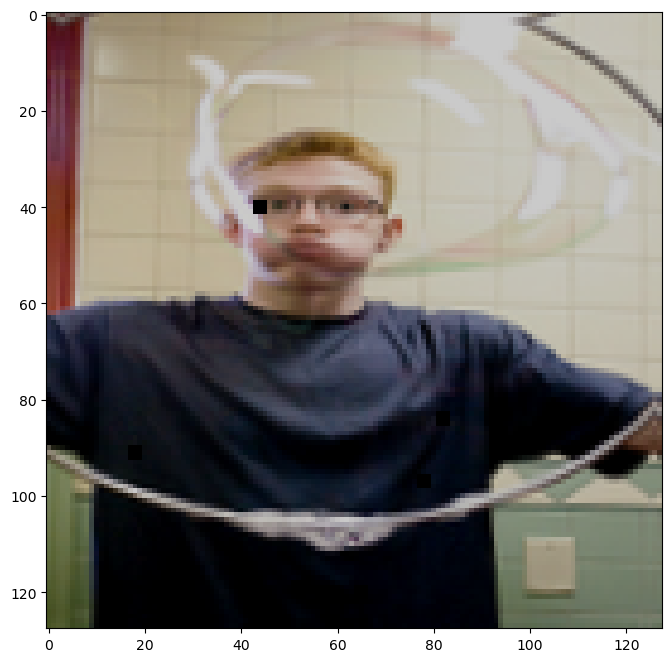

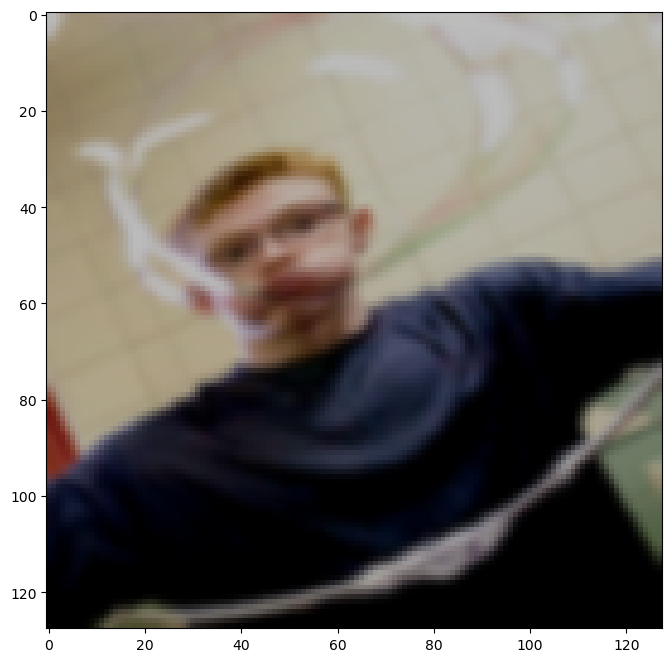

In [6]:
ag_img = process_images(data_dict['train_images'][0], image_size=image_size, augment=True)
for i in range(ag_img.shape[0]):
    img = ag_img[i].permute(1, 2, 0).to(torch.int32)
    plt.imshow(img)
    plt.show()

In [7]:
data_dict['train_captions'].shape

torch.Size([7281, 5, 38])

In [8]:
len(data_dict["vocab"]["idx_to_token"])

8456

We have 6,472 lists of captions. 

- Each list contains 5 captions.  
- Each caption consists of 40 tokens (with padding).  
- Each token is represented as a vector of size 8,908 (one-hot encoding).  


In [9]:
PAD_index = 0

`start = 1`,
`end = 2`,
`pad = 0`

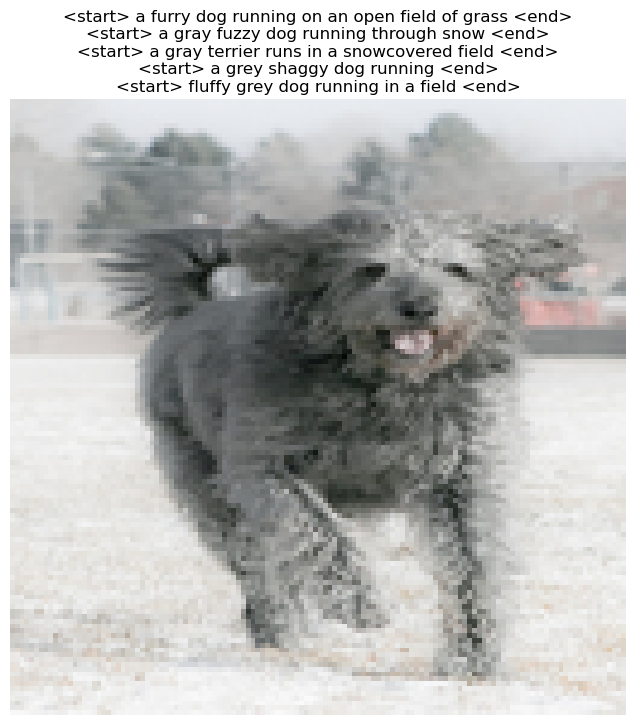

In [10]:
# Sample a minibatch and show the reshaped 112x112 images and captions
image_num = 1375

sample_images = data_dict['train_images'][image_num]
sample_captions = data_dict['train_captions'][image_num]
plt.imshow(process_images(sample_images, image_size=image_size).permute(1, 2, 0).to(torch.int32))
plt.axis('off')
caption_str = decode_captions(sample_captions, data_dict['vocab']['idx_to_token'])
caption_str = "\n".join(caption_str)
plt.title(caption_str)
plt.show()

### RNN

In [11]:
# create the image captioning model
rnn_model = CaptioningRNN(
          cell_type='attention',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=2048, 
          hidden_dim=512,
          wordvec_dim=256,
          ignore_index=PAD_index,
          **to_float_cuda)

In [12]:
word_to_idx=data_dict['vocab']['token_to_idx']['<pad>']
word_to_idx

0

In [13]:
lr = 8e-3
epochs = 60
lr_decay = 0.97
batch_size=256
weight_decay = 5e-4
interval = 30

# Model and file paths
name = 'attention'
version = 2
checkpoint_path = f'./checkpoint/{name}_{version}_checkpoint.pth'
model_path = f'./models/{name}_{version}_checkpoint.pth'
history_path = f'./history/{name}_{version}.pth'

if os.path.exists(checkpoint_path):
    # Resume training from checkpoint
    print(f"Resuming training from checkpoint: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)
    model = rnn_model.to(device)
    model.load_state_dict(checkpoint['model_state'])

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    optimizer.load_state_dict(checkpoint['optimizer_state'])

    scheduler = optim.lr_scheduler.LambdaLR(optimizer,lambda epoch: lr_decay ** epoch)
    # scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: lr_decay ** (epoch // interval))

    # scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

    if checkpoint['scheduler_state'] is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state'])

    start_epoch = checkpoint['epoch']
    train_loss_history = checkpoint['train_loss_history']
    val_loss_history = checkpoint['val_loss_history']
    best_val_loss = checkpoint['best_val_loss']
    print(f"Training will resume from epoch {start_epoch}.\n")

else:
    # Start new training
    print(f"Training new model: {name}\n")

    # Initialize model and optimizer
    model = rnn_model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # optimizer = optim.SGD(model.fc.parameters(), min_lr)

    # Define scheduler
    scheduler = optim.lr_scheduler.LambdaLR(optimizer,lambda epoch: lr_decay ** epoch)
    # scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: lr_decay ** (epoch // interval))

    # scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

    # Initialize metrics and state
    start_epoch = 0
    best_val_acc = 0.0

# Train model
train_loss_history, val_loss_history = train_captioning_model(
    rnn_model, optimizer, data_dict, device='cuda', dtype=torch.float32,
    epochs=epochs, batch_size=batch_size, scheduler=scheduler, val_perc=1,
    image_size=image_size, verbose=True, checkpoint_path=checkpoint_path
)

# Save final model and history after training completes
torch.save(model.state_dict(), model_path)
print(f"Final model saved at: {model_path}")

with open(history_path, 'wb') as f:
    pickle.dump((train_loss_history, val_loss_history), f)
print(f"Training history saved at: {history_path}")



Training new model: attention

Epoch 1/60
  Batch 1/28, Loss = 104.7771
  Batch 11/28, Loss = 65.7229
  Batch 21/28, Loss = 61.8014
  Training Loss: 68.7536
  Validation Loss: 57.1441
Epoch 2/60
  Batch 1/28, Loss = 56.7302
  Batch 11/28, Loss = 56.7346
  Batch 21/28, Loss = 53.8662
  Training Loss: 54.3228
  Validation Loss: 50.5956
Epoch 3/60
  Batch 1/28, Loss = 51.3469
  Batch 11/28, Loss = 49.4109
  Batch 21/28, Loss = 49.1242
  Training Loss: 49.1061
  Validation Loss: 47.1790
Epoch 4/60
  Batch 1/28, Loss = 48.3531
  Batch 11/28, Loss = 46.5829
  Batch 21/28, Loss = 42.7171
  Training Loss: 46.3066
  Validation Loss: 45.0562
Epoch 5/60
  Batch 1/28, Loss = 45.7017
  Batch 11/28, Loss = 46.1659
  Batch 21/28, Loss = 46.1603
  Training Loss: 44.4895
  Validation Loss: 43.5079
Epoch 6/60
  Batch 1/28, Loss = 43.3047
  Batch 11/28, Loss = 42.9285
  Batch 21/28, Loss = 43.1675
  Training Loss: 42.8218
  Validation Loss: 42.6689
Epoch 7/60
  Batch 1/28, Loss = 43.8264
  Batch 11/28, L

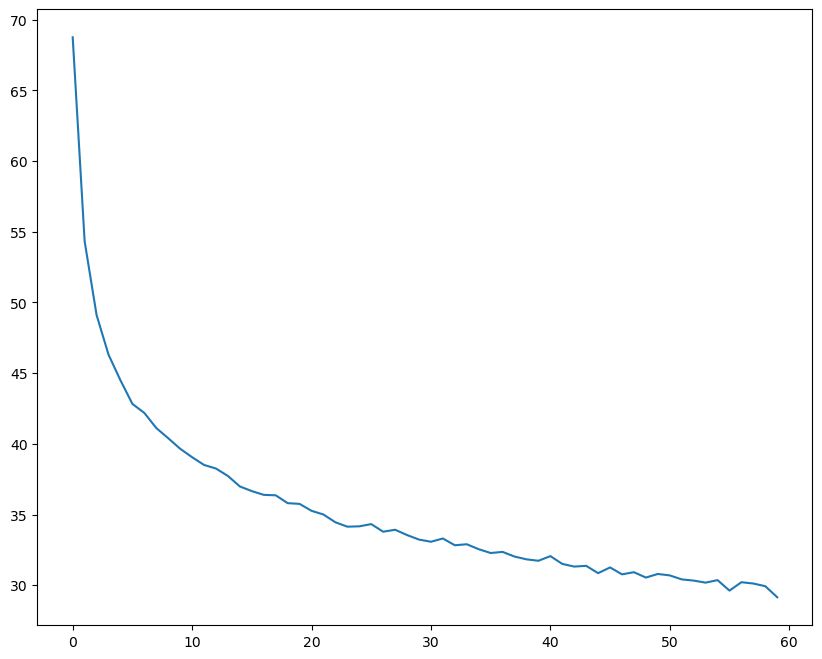

In [14]:
plt.plot(train_loss_history)

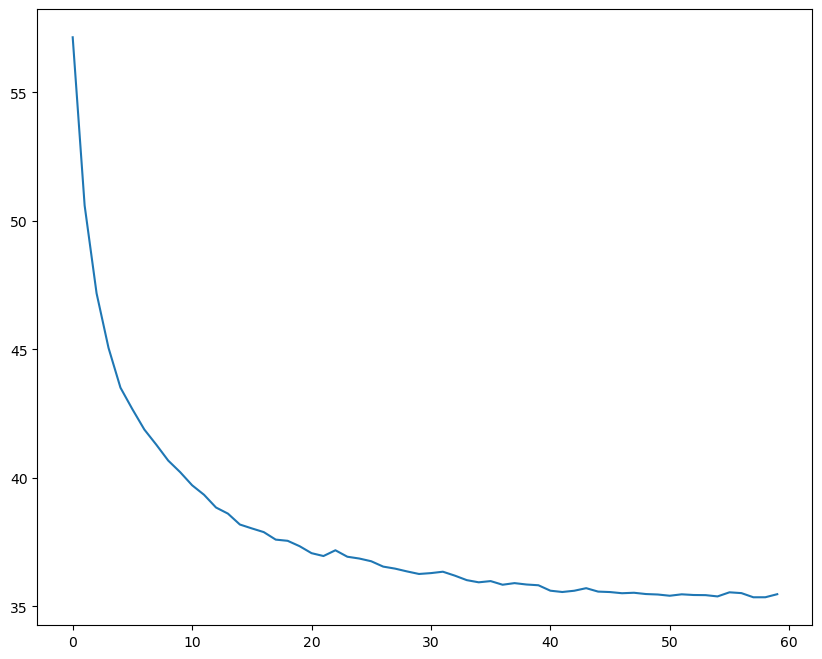

In [15]:
plt.plot(val_loss_history)

In [16]:
batch_size = 1
from torchvision.utils import make_grid
from torchvision import transforms

for split in ['train', 'val']:
  sample_idx = torch.randint(0, num_train if split=='train' else num_val, (batch_size,))
  sample_images = data_dict[split+'_images'][sample_idx]
  sample_captions = data_dict[split+'_captions'][sample_idx][:,0,:]

  # decode_captions is loaded from a4_helper.py
  gt_captions = decode_captions(sample_captions, data_dict['vocab']['idx_to_token'])
  rnn_model.eval()
  generated_captions, attn_weights_all = rnn_model.sample(sample_images)
  generated_captions = decode_captions(generated_captions, data_dict['vocab']['idx_to_token'])

  for i in range(batch_size):
    plt.imshow(sample_images[i].permute(1, 2, 0))
    plt.axis('off')
    plt.title('%s\nAttention LSTM Generated:%s\nGT:%s' % (split, generated_captions[i], gt_captions[i]))
    plt.show()
    
    tokens = generated_captions[i].split(' ')
    
    vis_attn = []
    for j in range(len(tokens)):
      img = sample_images[i]
      attn_weights = attn_weights_all[i][j]
      token = tokens[j]
      img_copy = attention_visualizer(img, attn_weights, token)
      vis_attn.append(transforms.ToTensor()(img_copy))
    
    plt.rcParams['figure.figsize'] = (20.0, 20.0)
    vis_attn = make_grid(vis_attn, nrow=8)
    plt.imshow(torch.flip(vis_attn, dims=(0,)).permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    plt.rcParams['figure.figsize'] = (10.0, 8.0)

AttributeError: 'numpy.ndarray' object has no attribute 'new'